In [36]:
import re
from collections import defaultdict
from pathlib import Path

import librosa as lbr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from rich.progress import track

In [2]:
src = Path("/run/media/nathan/Nathan4T/Nathan-canarygan/generation")
archives = defaultdict(list)
for file in src.glob("version_*/*.npz"):
    m = re.search(r"generation-version_(?P<version>[0-9]+)-epoch_(?P<epoch>[0-9]+)-step_(?P<step>[0-9]+)\.npz", file.name)
    version, epoch, step = m.groups()
    archives["version"].append(int(version))
    archives["epoch"].append(int(epoch))
    archives["step"].append(int(step))
    archives["file"].append(str(file))

    d = np.load(file)
    
    archives["y"].append(d["y"].tolist())
    archives["y_max"].append(d["y_max"].tolist())
    archives["y_mean"].append(d["y_mean"].tolist())
    archives["y_argmax"].append(d["y_argmax"].tolist())
    archives["y_sum"].append(d["y_sum"].tolist())
    archives["z"].append(d["z"])
    archives["idx"].append(list(range(len(d["y"].tolist()))))
    
df = pd.DataFrame(archives).sort_values(by=["version", "epoch"])
df = df.explode(["y", "y_max", "y_mean", "y_argmax", "y_sum", "z", "idx"]).reset_index(drop=True)
df

,version,epoch,step,file,y,y_max,y_mean,y_argmax,y_sum,z,idx
0,0,14,1350,/run/media/nathan/Nathan4T/Nathan-canarygan/ge...,A,EARLY_42561,A,EARLY_42561,A,"[0.9274787, -0.22017372, -0.7341025]",0
1,0,14,1350,/run/media/nathan/Nathan4T/Nathan-canarygan/ge...,EARLY_42561,EARLY_7370,EARLY_42561,EARLY_7370,EARLY_42561,"[-0.67952824, -0.82554984, 0.42500174]",1
2,0,14,1350,/run/media/nathan/Nathan4T/Nathan-canarygan/ge...,EARLY_42561,EARLY_42561,EARLY_42561,EARLY_42561,EARLY_42561,"[0.11907542, -0.27371383, -0.24401593]",2
3,0,14,1350,/run/media/nathan/Nathan4T/Nathan-canarygan/ge...,EARLY_42561,EARLY_1120,EARLY_42561,EARLY_1120,EARLY_42561,"[-0.90570724, -0.9862453, 0.06575799]",3
4,0,14,1350,/run/media/nathan/Nathan4T/Nathan-canarygan/ge...,EARLY_42561,EARLY_42561,EARLY_42561,EARLY_42561,EARLY_42561,"[-0.58226407, -0.23770642, 0.38074744]",4
...,...,...,...,...,...,...,...,...,...,...,...
2599995,19,989,89100,/run/media/nathan/Nathan4T/Nathan-canarygan/ge...,EARLY_False,OT_80795,EARLY_False,OT_80795,EARLY_False,"[-0.07280195, -0.24597394, -0.46060765]",9995
2599996,19,989,89100,/run/media/nathan/Nathan4T/Nathan-canarygan/ge...,EARLY_False,EARLY_7401,EARLY_False,EARLY_7401,EARLY_False,"[0.44656813, 0.70741606, 0.6518117]",9996
2599997,19,989,89100,/run/media/nathan/Nathan4T/Nathan-canarygan/ge...,H,EARLY_42561,H,EARLY_42561,H,"[0.46065593, -0.64441, 0.5408428]",9997
2599998,19,989,89100,/run/media/nathan/Nathan4T/Nathan-canarygan/ge...,D,OT_57765,D,OT_57765,D,"[-0.00019216537, 0.71117103, 0.81589675]",9998


In [8]:
src = Path("/run/media/nathan/Nathan4T/Nathan-canarygan/reports/inverse_model_max/")
res = {}
for file in src.glob("version_*.npz"):
    m = re.search(r"version_(?P<version>[0-9]+)_epoch_(?P<epoch>[0-9]+)\.npz", file.name)
    version, epoch = m.groups()
    res[f"{version}-{epoch}"] = file 

In [41]:
d = np.load(res["3-989"])
print(list(d.keys()))

['last_w', 'w_history', 'm_r_base', 'x_gens', 'y_gens', 'version', 'epoch', 'p95', 'sorted_classes']


In [42]:
class_to_idx = {k: i for i, k in enumerate(d["sorted_classes"])}
idx_to_class = {i: k for i, k in enumerate(d["sorted_classes"])}

In [43]:
d["m_r_base"].shape

(3, 16, 400, 3)

In [58]:
d["y_gens"].shape

(3, 16, 400, 16)

In [50]:
np.hstack(d["x_gens"].reshape(3, 16, -1, 16384)).shape

(16, 1200, 16384)

In [38]:
space_imgs = src / "motor_trajectory"
space_imgs.mkdir(parents=True, exist_ok=True)

for key, file in track(res.items()):
    version, epoch = [int(k) for k in key.split("-")]
    d = np.load(file)
    m_r_base = d["m_r_base"]
    fig, axs = plt.subplots(4, 4, figsize=(10, 10), subplot_kw={'projection': '3d'})
    t = np.arange(m_r_base.shape[-2])
    
    zdf = df.query("version==@version & epoch==@epoch")
    
    axs = axs.flatten()

    fig.suptitle(f"version={version}, epoch={epoch}")
    
    for i in range(m_r_base.shape[-3]):  # except X class
        ax = axs[i]
        lbl = idx_to_class[i]

        z3d = zdf.query("y_argmax==@lbl").z.values
        if len(z3d) > 0:
            z3d = tuple(np.vstack(z3d).T)
            
            ax.set_xlim(-1.01, 1.01)
            ax.set_ylim(-1.01, 1.01)
            ax.set_zlim3d(-1.01, 1.01)
            
            ax.scatter(*z3d, s=40, c="C1", lw=0, alpha=0.1)
    
        for j in range(m_r_base.shape[0]):
            m_coords = m_r_base[j, i]
            ax.scatter(m_coords[:, 0], m_coords[:, 1], m_coords[:, 2], s=3, c=t, alpha=0.1, cmap="coolwarm")
    
        ax.set_title(lbl)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    fig.savefig(space_imgs / f"motor_trajectory-version_{version}-epoch_{epoch}.pdf", bbox_inches="tight")

    plt.close()

Output()

In [59]:
mean_spec_dir = src / "mean_spectrograms"
mean_spec_dir.mkdir(parents=True, exist_ok=True)

sr = 16000
up_to = 400

for key, file in track(res.items()):
    version, epoch = [int(k) for k in key.split("-")]
    d = np.load(file)
    
    y_gens = np.hstack(d["y_gens"][:, :, :up_to, :])
    p_dim = y_gens.shape[-1]
    y_gens = np.concatenate([y_gens[i, :, i][:, np.newaxis] for i in range(p_dim)], axis=1)

    n, _, audio_len = d["x_gens"].shape
    x_gens = d["x_gens"].reshape(n, p_dim, -1, audio_len)
    x_gens = x_gens[:, :, :up_to, :]
    x_gens = np.hstack(x_gens)

    fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    fig.suptitle(f"version={version}, epoch={epoch}")
    
    for i in range(16):
        y = y_gens[:, i]
        x = x_gens[i, :, :round(sr*0.3)]
        x_sel = x[y >= 0.99]
        n = x_sel.shape[0]
        ax = axs[i]
        if x_sel.shape[0] > 0:
            s = lbr.stft(y=x_sel, n_fft=256, hop_length=64) # hop_length=hop_length, win_length=win_length)
            s = np.log(1 + 100 * np.abs(s)**2)
            sm = np.mean(s, axis=0)
            
            ax.imshow(sm, origin="lower", aspect="auto", cmap="inferno")

        lbl = idx_to_class[i]
        ax.set_title(f"{lbl} (n={n})")

    fig.savefig(mean_spec_dir / f"mean_spec-version_{version}-epoch_{epoch}.pdf", bbox_inches="tight")

    plt.close()

Output()

In [62]:
activity_dir = src / "activity"
activity_dir.mkdir(parents=True, exist_ok=True)

up_to = 200

for key, file in track(res.items()):
    version, epoch = [int(k) for k in key.split("-")]
    d = np.load(file)
    
    y_gens = np.mean(d["y_gens"][:, :, :up_to, :], axis=0)
    y_gens_std = np.std(d["y_gens"][:, :, :up_to, :], axis=0)
    p_dim = y_gens.shape[-1]
    y_gens = np.concatenate([y_gens[i, :, i][:, np.newaxis] for i in range(p_dim)], axis=1)
    y_gens_std = np.concatenate([y_gens_std[i, :, i][:, np.newaxis] for i in range(p_dim)], axis=1)
    
    fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        lbl = idx_to_class[i]
        ax.plot(y_gens[:, i])
        ax.fill_between(y_gens[:, i] - y_gens_std[:, i], y_gens[:, i] + y_gens_std[:, i], alpha=0.1)
        ax.set_title(lbl)

    fig.savefig(activity_dir / f"activity-version_{version}-epoch_{epoch}.pdf", bbox_inches="tight")

    plt.close()

Output()

In [6]:
inverse_test = src / "test_inverse_3_989.npz"
d = np.load(inverse_test)

In [7]:
class_to_idx = np.load(src / "test_inverse_3_989_max.class_to_idx.npz")
class_to_idx = {k: int(v) for k, v in class_to_idx.items()}
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [8]:
m_base_register = d["m_base_register"]
m_base_register.shape

(16, 400, 3)

In [9]:
p_dim, n_steps, m_dim = m_base_register.shape

In [10]:
x_gens = d["x_gens"].reshape(p_dim, -1, d["x_gens"].shape[-1])
x_gens.shape

(16, 400, 16384)

In [11]:
y_ms = d["y_ms"]
y_ms_syll = np.concatenate([y_ms[i, :, i][:, np.newaxis] for i in range(p_dim)], axis=1)
y_ms_syll.shape

(400, 16)

Text(0, 0.5, '95nth activity percentile')

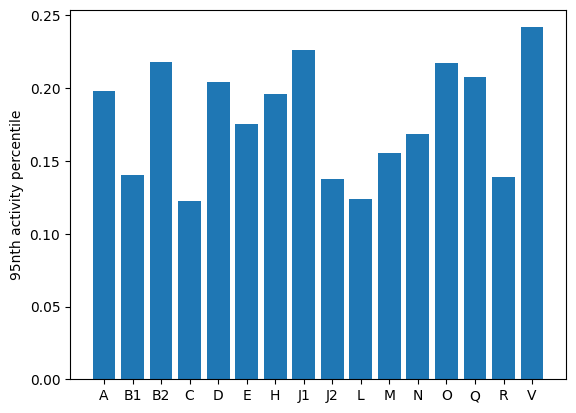

In [12]:
plt.bar([idx_to_class[i] for i in range(len(d["p95"]))], d["p95"])
plt.ylabel("95nth activity percentile")

In [13]:
spec_means = []
sr = 16000
# hop_length = round(sr * 0.01)
# win_length = round(sr * 0.02)

up_to = 400

for i in range(16):
    y = y_ms_syll[:up_to, i]
    x = x_gens[i, :up_to, :round(16000*0.3)]
    x_sel = x[y >= 0.99]
    if x_sel.shape[0] > 0:
        s = lbr.stft(y=x_sel, n_fft=256, hop_length=64) # hop_length=hop_length, win_length=win_length)
        s = [np.log(1 + 100 * np.abs(si)**2) for si in s]
        sm = np.mean(s, axis=0)
        # sm = lbr.power_to_db(sm)
        spec_means.append(sm)
    else:
        spec_means.append(None)

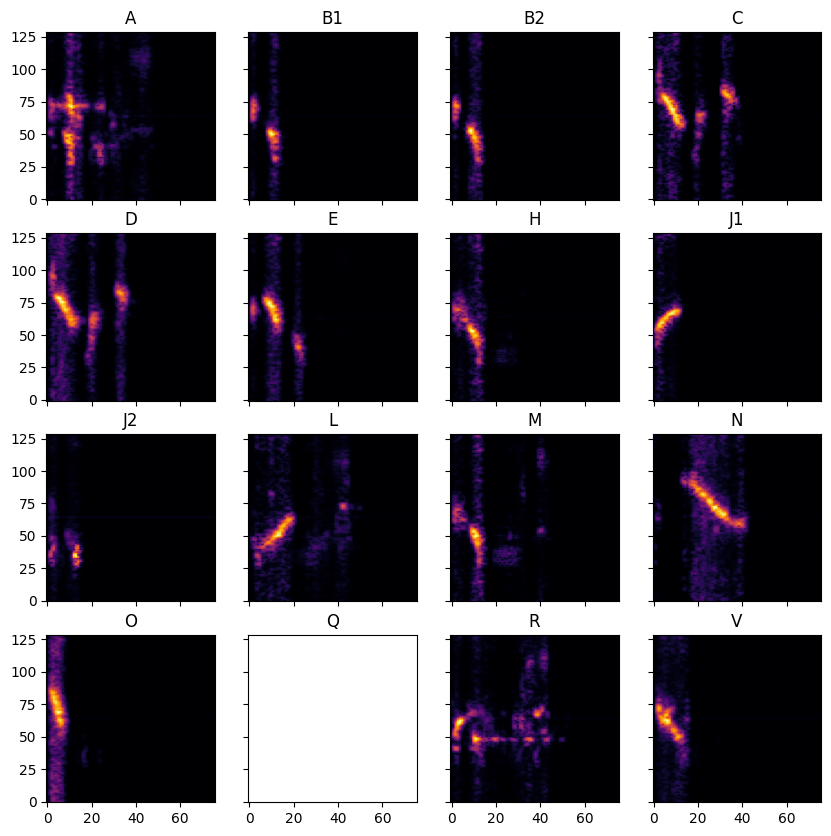

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i, ax in enumerate(axs):
    s = spec_means[i]
    if s is not None:
        ax.imshow(s, origin="lower", aspect="auto", cmap="inferno")
    lbl = idx_to_class[i]
    ax.set_title(lbl)

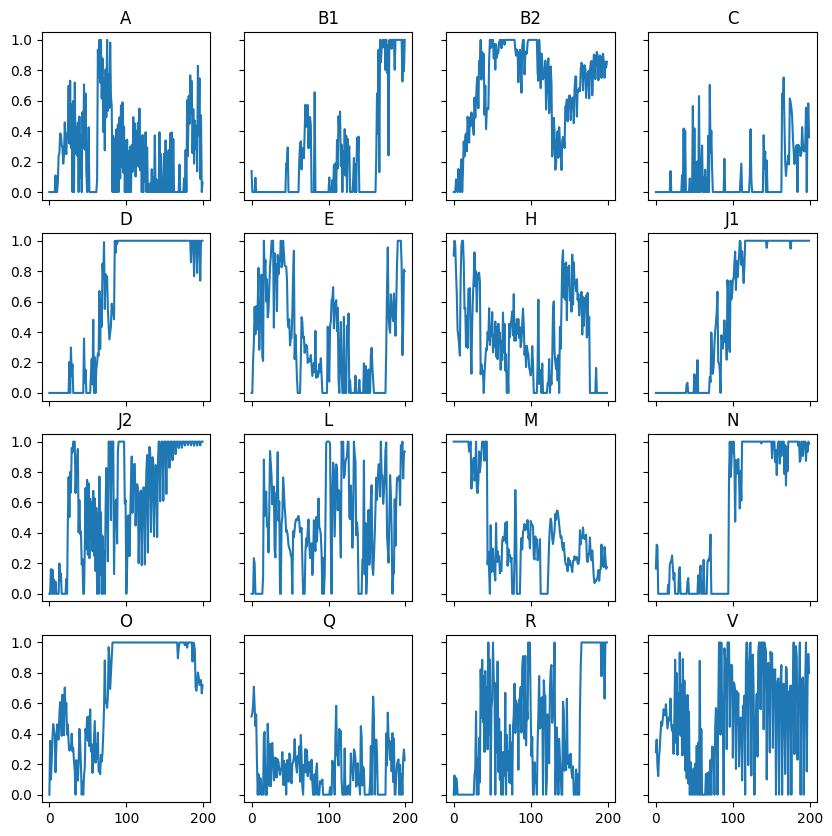

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()
up_to = 200
for i, ax in enumerate(axs):
    lbl = idx_to_class[i]
    ax.plot(y_ms_syll[:up_to, i])
    ax.set_title(lbl)

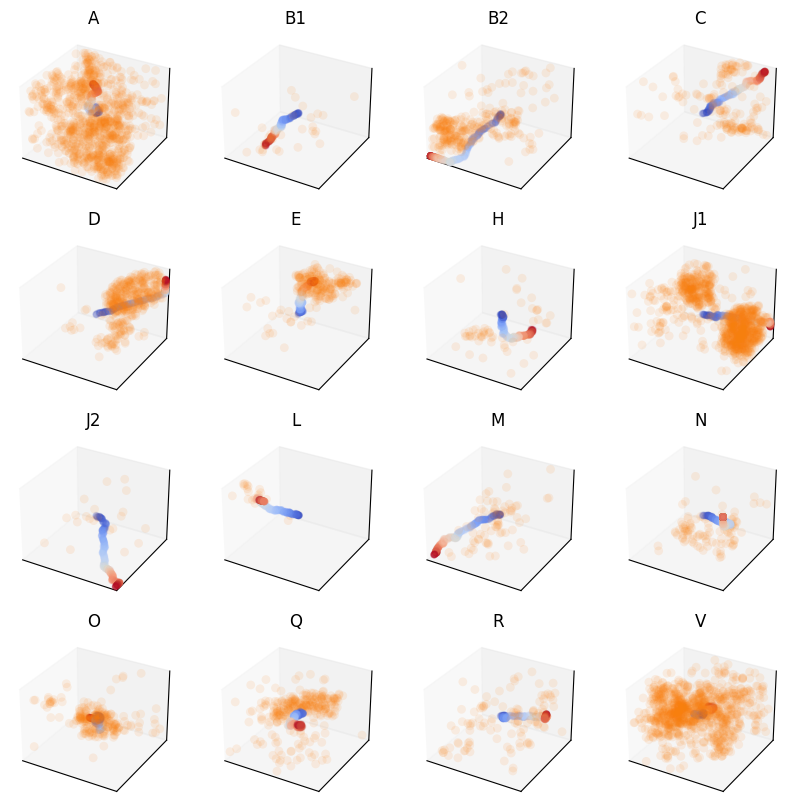

In [21]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10), subplot_kw={'projection': '3d'})
t = np.arange(m_base_register.shape[1])

zdf = df.query("version==3 & epoch==989")

axs = axs.flatten()

for i, m_coords in enumerate(m_base_register):  # except X class
    ax = axs[i]
    lbl = idx_to_class[i]
    
    z3d = tuple(np.vstack(zdf.query("y_argmax==@lbl").z.values).T)
    
    ax.set_xlim(-1.01, 1.01)
    ax.set_ylim(-1.01, 1.01)
    ax.set_zlim3d(-1.01, 1.01)
    
    ax.scatter(*z3d, s=40, c="C1", lw=0, alpha=0.1)
    ax.scatter(m_coords[:, 0], m_coords[:, 1], m_coords[:, 2], c=t, alpha=0.1, cmap="coolwarm")

    ax.set_title(lbl)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])